<center>Agustina Garcia Saenz, Javier Cejudo, David Gadyt, Thorsten Brückner<br>
<center>March 15, 2023<br><br><br>
<hr style="height:5px;border-width:0;color:orange;background-color:green">
<center><b><span style="font-size: 32px; color: green;"> Bob's Analysis Task</b></span></center>

<a id="0"></a>
<font color=green size=+3><b>0 - Module Summary</b></font>

This module focus on the analysis of the data given by easyMoney with the main objective of understanding the current state of the company in terms of product performance, sales figures, demographics of the user base and other information that might be valuable not only business wise but also for segmentation and recommendation machine learning models tasks. 

In order to do so, each feature has been analyzed in depth individually and some of them also in combination with other features so to maximize the insight we can gain from a broad look at the data, some visualization (tabular and graphical) methods have been used for this purpose. 

The main results have been:
* the identification of the best products in terms of customer acquisition and retention (EM accounts),
* the identification of products with zero or very few customers (EM account +, EM account ++),
* the seasonality of customer acquisition, usually going from July to December of a given year together with the entry channels that were useful during the mentioned seasons (KHE, KHM, KHN). 
* The active customer rate analysis per month
* the average product per customer per month 



<a id="0.1"></a>
<font color=green size=+3><b>0.1 - Data Assumptions and Constraints</b></font>

**Due to the poor quality of the data provided and the lack of clarity in the definition of some features, some assumptions were made to guide the fulfillment of the tasks.**


<font color=green size=+1><b>Assumptions</b></font><br>


* The data is organized by customer ID (pk_cid) and per month, providing an overall picture of each customer for a given month.
* The data provided is assumed to be corrected and provides a clear picture of the customer base.
* Active Customer: Assumes that activity is measured based on the CTR metric. It is assumed that the company developed a model to identify if a customer is active or not for a given month.
* Products: The Boolean values represent customer activity of a product for a specific month. For example, if the debit card was used in a given month, it will show 1, if not, it will show 0.
* Entry_date: The definition provided stated that entry_date is “Date on which the first easyMoney contract was signed”. After checking the data by plotting the customers with 0 products, it was expected to find a Null date since these customers never signed a new contract. This is more evident for new customers that arrived from 2018 forward. * The assumption is entry_date is the date where the customer created an account in the easyMoney platform and it is not related to the acquisition of any product.

<font color=green size=+1><b>Constraints</b></font><br>

* The data provided is scarce. For four years since the company was created, only one and a half years of partitions are available. This limits the understanding of the behavior of the customers.
* The features provided contain many errors and require manipulations. For example, the gender feature per customer contains more than one gender. Also, the age feature presents multiple ages for the same customer.
* Another main constraint is the inability to understand when a certain product was introduced. By knowing the product introduction date, it would have been possible to understand its evolution and draw better conclusions.
* It is not clear when a customer signed a new product. Making the recommendation task very challenging.
* Both past revenue and cost are not provided. With these features it would have been easier to understand the contribution of some products for the overall profitability.


<a id="0.2"></a>
<font color=green size=+3><b>0.2 - Module Imports & Configurations</b></font>

In [112]:
# Import libraries
import numpy as np # Library for numerical computations in Python
import pandas as pd # Library for data manipulation and analysis in Python

# Data Visualization
import seaborn as sns # Library for data visualization based on matplotlib
import matplotlib.pyplot as plt # Library for creating static visualizations in Python

# Datetime
import datetime as dt # Library for working with dates and times in Python

# Random
import random # Library "random"  for generating random numbers

# Warnings 
import warnings # Library for managing warnings in Python
warnings.filterwarnings('ignore') # Ignore any warnings
warnings.warn("this will not show") # A warning that will not be displayed

# Pandas formatting
pd.set_option('display.max_rows', 100) # Set maximum number of rows to display in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Set the floating point number format for display in Pandas
pd.set_option('max_colwidth',200) # Set maximum column width for display in Pandas
pd.set_option('display.colheader_justify', 'center') # Set the header alignment for display in Pandas


<a id="0.3"></a>
<font color=green size=+3><b>0.3 - Function Definitions</b></font>

Centralizing the necessary functions helps to maintain organization and clarity in the notebook.<br>
This allows easy calling as required without sacrificing the code's readability.

In [262]:

def cat_uni_values(data):
    """
    This function takes in a Pandas dataframe and prints out the unique values of each categorical column
    """
    cat = data.select_dtypes(include=['object'])
    for columns in cat:
        categories = data[columns].unique()
        print('[{}] has {} unique values\n'.format(columns, categories))   

###############################################################################################################################

def numerical(data):
    """
    This function takes in a Pandas dataframe and prints out the number of unique values in each numerical column
    """
    num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    
    print('The dataframe contains [{}] numerical features out of [{}] features:'.format(len(num),data.shape[1]))
    
    for columns in num:
        categories = len(data[columns].unique())
        print('Column [{}] has [{}] unique values'.format(columns, categories))

###############################################################################################################################        

def missing_values (data):
    """
    This function takes in a Pandas dataframe and returns a dataframe that displays the number and percentage 
    of missing values in each column, sorted by percentage of missing values in descending order.
    """
    missing_number = data.isnull().sum().sort_values(ascending=False)
    missing_percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Percentage %'])
    return missing_values

###############################################################################################################################
    
def outliers(data):
    """
    This function takes in a Pandas dataframe and prints out the number of upper and lower outliers for each numerical column 
    using the interquartile range method.
    """
    numeric_features = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    for col in numeric_features:
        temp = data.copy()
        temp.dropna(axis = 0, subset = [col], inplace = True)
        mini, maxi = temp[col].min(), temp[col].max()
        Q1, Q3 = np.quantile(temp[col], 0.25), np.quantile(temp[col], 0.75)
        IQR = Q3 - Q1
        lower_range, upper_range = (Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR)
        outliers_upper = len(temp[temp[col] > upper_range])
        outliers_lower = len(temp[temp[col] < lower_range])
        print('df["{}"]'.format(col))
        print("Min: {}, Max: {}, Q1: {}, Q3: {}".format(mini, maxi, Q1, Q3))
        print("IQR: {}" .format(IQR))
        print("LOWER/UPPER Range: {} / {}" .format (lower_range, upper_range))
        print("Total LOWER/UPPER outliers: {} / {}\n".format (outliers_lower, outliers_upper))

###############################################################################################################################        

def stringify_df(data):
    '''
    Converts selected columns of a dataframe to strings for easier data manipulation

    Args:
    data (pd.DataFrame): the input dataframe

    Returns:
    pd.DataFrame: a dataframe where selected columns have been converted to strings
    '''
    data = data.copy(deep=True)
    to_stringify = ["em_acount", "emc_account", "short_term_deposit", "long_term_deposit", 
                    "loans", "mortgage", "funds", "securities", "debit_card", "credit_card", "pension_plan", 
                    "payroll", "payroll_account", "active_customer"]
 
    string_DF = pd.DataFrame(index=data["pk_cid"].unique())

    for feature in to_stringify:
        pivot_table = data.pivot_table(index="pk_cid", columns="pk_partition", values=feature, aggfunc="first")
        temp_table = pivot_table.applymap(lambda x: str(int(x)) if pd.notnull(x) else "x")
        temp_table[feature] = temp_table.apply(lambda row: "".join(row.values), axis=1)
        string_DF = pd.concat([string_DF, temp_table[feature]], axis=1)
        
    return string_DF
###############################################################################################################################
def get_best_products(df,col):
    products=['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card', 'debit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'em_acount']
    
    # create an empty dictionary to hold the results
    results = {col: [], 'best_product': [], 'second_best_product': [], 'third_best_product': []}

    # loop through each entry channel class
    for channel in df[col].unique():
        channel_df = df[df[col] == channel]  # get dataframe for current channel

        # calculate sum of each product for current channel
        product_totals = channel_df[products].sum()

        # sort the products in descending order
        sorted_products = product_totals.sort_values(ascending=False)

        # add the results to the dictionary
        results[col].append(channel)
        results['best_product'].append(sorted_products.index[0])
        results['second_best_product'].append(sorted_products.index[1])
        results['third_best_product'].append(sorted_products.index[2])

    # create a dataframe from the results dictionary
    results_df = pd.DataFrame(results)

    # return the results dataframe
    return results_df

###############################################################################################################################

def feature_vs_target_w_lengh(data, feature, TARGET, active_customers = True, grouped = True):

    title_sub = ""
    if active_customers == True:
        data[data["active_customer"] == 1]
        title_sub = "Active customers"
    if grouped == True:
        data = data.drop_duplicates(subset = "pk_cid", keep = "last")
        title_sub = "Unique " + title_sub
    
    sleep_pivot = data.pivot_table(
        index = [feature], values = TARGET,
        aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

    fig, ax = plt.subplots(figsize=(15, 7))
    scatter = ax.scatter(
        sleep_pivot.index, sleep_pivot[("mean", TARGET)], c = sleep_pivot[("len", TARGET)], 
        cmap = "viridis", alpha = 0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel(TARGET + " rate")
    ax.set_title(title_sub + "\n" + feature + " vs " + TARGET + " Rate")
    cbar = fig.colorbar(scatter)
    cbar.set_label("cardinality of observations")
    plt.show()

###############################################################################################################################

def four_feature_scatterer(data, category, aggfunc, grouped=True, subset=False):

    title = f"by {category}<br>{list(aggfunc.keys())[0]} vs {list(aggfunc.keys())[1]} vs {list(aggfunc.keys())[2]}"

    if subset != False:
        data = data[data[subset[0]] == subset[1]]
        title = f"{subset[0]} {title}  "
    if grouped == True:
        df_prep = data.groupby(["pk_cid", category]).agg(aggfunc).reset_index()
        vis_data = df_prep.groupby(category).agg(aggfunc).sort_values(by=list(aggfunc.keys())[2], ascending=False)
    else:
        vis_data = data.groupby(category).agg(aggfunc).sort_values(by=list(aggfunc.keys())[2], ascending=False)

    g = sns.scatterplot(data=vis_data, x=list(aggfunc.keys())[0], y=list(aggfunc.keys())[1],
                        hue=vis_data.index, size=list(aggfunc.keys())[2], sizes=(50, 500))

    plt.title(title)
    plt.xlabel(list(aggfunc.keys())[0])
    plt.ylabel(list(aggfunc.keys())[1])
    plt.show()

###############################################################################################################################

def fillna_ffill(df, feature):
    missing_data = df[df[feature].isnull()]['pk_cid'].unique().tolist()
    df_missing = df[df['pk_cid'].isin(missing_data)][['pk_cid', feature]].sort_values(by='pk_cid')
    df_missing[feature] = df_missing[feature].fillna(method='ffill')
    df.loc[df_missing.index, feature] = df_missing[feature]
    return df


<a id="1"></a>
<font color=green size=+3><b>1 - Data Understanding</b></font>

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">


<font color=green size=+3><b>1.1 - Data Import</b></font>

In [114]:
## read the data
df=pd.read_csv('Bobs_df.csv', index_col=0)

In [115]:
print('The dataset contains [{}] rows and [{}] columns.'.format(df.shape[0],df.shape[1]))

The dataset contains [5962924] rows and [27] columns.



<font color=green size=+3><b>1.2 - Global variables</b></font>

In [116]:
products=['short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card', 'debit_card',
       'payroll', 'pension_plan', 'payroll_account', 'emc_account',
       'em_account_p', 'em_acount','em_account_pp']

<font color=green size=+3><b>1.3 - Generic look at the data</b></font>

In [117]:
df.head(5).T

,0,1,2,3,4
pk_cid,1375586,1050611,1050612,1050613,1050614
pk_partition,2018-01-28,2018-01-28,2018-01-28,2018-01-28,2018-01-28
country_id,ES,ES,ES,ES,ES
region_code,29.00,13.00,13.00,50.00,50.00
gender,H,V,V,H,V
age,35,23,23,22,23
deceased,N,N,N,N,N
salary,87218.10,35548.74,122179.11,119775.54,NaN
short_term_deposit,0,0,0,1,0
loans,0,0,0,0,0


**Each row represents a month by customer, and each column represents a feature or attribute of the customer.** 

In [118]:
# Missing values

missing_values(df).head(8)

,Missing_Number,Percentage %
salary,1512103,25.36
segment,133944,2.25
entry_channel,133033,2.23
region_code,2264,0.04
pension_plan,61,0.00
payroll,61,0.00
gender,25,0.00
credit_card,0,0.00


<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+3><b>2 - Feature Understanding </b></font>

<font color=green size=+3><b>2.1 - Feature Definitions </b></font>

The feature definitions shown below match the information provided by the easyMoney team

In [119]:
# Create a dictionary with the feature names and descriptions
features = {"pk_cid": "Customer identifier","pk_partition": "Data ingestion date",
    "country_id": "Country of residence of the client","region_code": "Customer's province of residence (for ES)",
    "gender": "Gender","age": "Customer age","deceased": "Deceased index. N/S",
    "salary": "Household gross income","short_term_deposit": "Short-term deposits",
    "loans": "Loans","mortgage": "Mortgage", "funds": "Investment funds",
    "securities": "Securities","long_term_deposit": "Long term deposits",
    "em_account_pp": "easyMoney++ account","credit_card": "Credit cards",
    "payroll": "Payroll","pension_plan": "Pension plan",
    "payroll_account": "Account awarded with a bonus due to payroll",
    "emc_account": "easyMoney Crypto account","debit_card": "Debit card",
    "em_account_p": "easyMoney+ account", "em_acount": "easyMoney account",
    "entry_date": "Date on which first easyMoney contract was signed",
    "entry_channel": "Customer acquisition channel",
    "active_customer": "Client activity indicator in our application",
    "segment": "Customer business segment"
        }

df_features = pd.DataFrame.from_dict(features, orient='index', columns=['Description'])
df_features

,Description
pk_cid,Customer identifier
pk_partition,Data ingestion date
country_id,Country of residence of the client
region_code,Customer's province of residence (for ES)
gender,Gender
age,Customer age
deceased,Deceased index. N/S
salary,Household gross income
short_term_deposit,Short-term deposits
loans,Loans


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   country_id          object 
 3   region_code         float64
 4   gender              object 
 5   age                 int64  
 6   deceased            object 
 7   salary              float64
 8   short_term_deposit  int64  
 9   loans               int64  
 10  mortgage            int64  
 11  funds               int64  
 12  securities          int64  
 13  long_term_deposit   int64  
 14  em_account_pp       int64  
 15  credit_card         int64  
 16  payroll             float64
 17  pension_plan        float64
 18  payroll_account     int64  
 19  emc_account         int64  
 20  debit_card          int64  
 21  em_account_p        int64  
 22  em_acount           int64  
 23  entry_date          object 
 24  entry_channel       obje

<font color=green size=+3><b>2.2 - Feature manipulation </b></font>

Pension Plan and Payroll include missing values. We will input the missing values forward filling the missing values.

In [121]:
# Input missing values 
fillna_ffill(df,'payroll')
fillna_ffill(df,'pension_plan')

# Change data type
df['payroll'] = df['payroll'].astype('Int8')
df['pension_plan'] = df['pension_plan'].astype('Int8')
df['active_customer'] = df['active_customer'].astype('Int8')

print(df[['payroll','pension_plan','active_customer']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 3 columns):
 #   Column           Dtype
---  ------           -----
 0   payroll          Int8 
 1   pension_plan     Int8 
 2   active_customer  Int8 
dtypes: Int8(3)
memory usage: 208.6 MB
None


**Total_Products:** Create a feature to sum the total number of products per customer on a given month

In [122]:
df['Total_products']=df[products].sum(axis=1)

**Dates:** Date features transform them to **Datetime**. Create month, year, quarter and year_month partition

For **entry_date** feature two dates are invalid and are corrected below

In [123]:
# pk_partition

df['pk_partition'] = pd.to_datetime(df['pk_partition'], format='%Y-%m-%d')

df['year_partition'] = df['pk_partition'].dt.year
df['month_partition'] = df['pk_partition'].dt.month
df['year_month_partition']=pd.to_datetime(df['pk_partition']).dt.to_period('M')

################################################################################

df['entry_date'] = df['entry_date'].replace('2015-02-29', '2015-02-28')
df['entry_date'] = df['entry_date'].replace('2019-02-29', '2019-02-28')

df['entry_date'] = pd.to_datetime(df['entry_date'], format='%Y-%m-%d')

df['quarter_entry'] = pd.to_datetime(df['entry_date']).dt.to_period('Q')
df['year_month_entry']=pd.to_datetime(df['entry_date']).dt.to_period('M')
df['year_month_entry']=df['year_month_entry'].dt.strftime('%Y-%m')
df['quarter_entry'] = df['quarter_entry'].dt.strftime('%Y-Q%q')


<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+3><b>2.3 - Feature Understanding</b></font>

<font color=green size=+2><b> [entry_date]</b></font>

In [124]:
# Customer distribution by entry_date
df_unique = df.drop_duplicates(subset=['pk_cid'], keep='last').groupby("quarter_entry").agg({"pk_cid": "count"})

display(df_unique.style.background_gradient())


,pk_cid
quarter_entry,
2015-Q1,6338
2015-Q2,7149
2015-Q3,40758
2015-Q4,38104
2016-Q1,7140
2016-Q2,6405
2016-Q3,40114
2016-Q4,42933
2017-Q1,11062


Q3-Q4 are the quarters where more customers become part of easyMoney.

In [125]:
customers = {}
for year in range(2015, 2020):
    start = (year - 2015) * 4
    end = start + 4
    quarter_range = df_unique.groupby("quarter_entry").agg({"pk_cid": "count"}).iloc[start:end]
    customers[f"customers_{year}"] = quarter_range.sum()
    print(f"The number of registrations in {year} was {quarter_range.sum().iloc[0]}")


The number of registrations in 2015 was 4
The number of registrations in 2016 was 4
The number of registrations in 2017 was 4
The number of registrations in 2018 was 4
The number of registrations in 2019 was 2


The number of registrations increase year by year, also 2019 shows a good trend with two very good quarters.

<AxesSubplot:title={'center':'Number of new Customer registrations over time'}, xlabel='entry_date'>

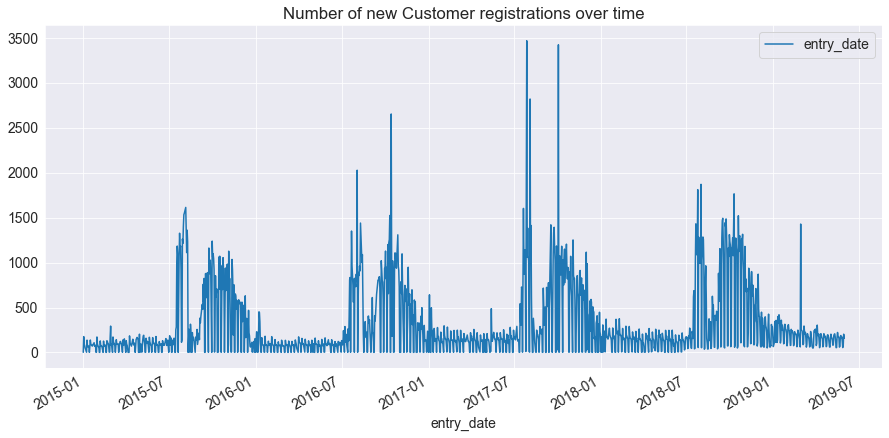

In [126]:
# Plot the distribution
df_unique = df.drop_duplicates(subset=['pk_cid'], keep='last')

df_unique.groupby("entry_date").agg({"entry_date": "count"}).plot(figsize = (15, 7), title = "Number of new Customer registrations over time")

<font color=green><b>Comments</b></font>:

Bulk customer acquisition appears to occur during specific seasons from July to December, with a peak in November. This trend has been consistent from 2015 to 2019, with the data stopping just before the expected peak in 2019.

The number of customers acquired during each season has increased over the years, indicating successful acquisition strategies.

Overall, the total number of new sign-ups has been increasing each year, suggesting successful customer acquisition effort

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Pk_partition]</b></font>

The PK partition represents the reporting date that reflects the current status of the data frame for a given month. By analyzing the number of customers reported in each partition, we can gain valuable insights into the distribution of data across different time periods.

<font color=green><b>Total Customers per month</b></font>:

,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
Total_Customers,239493,242521,245258,247463,249926,252104,339339,352922,375323,402300,416387,422481,426875,431727,436183,439627,442995


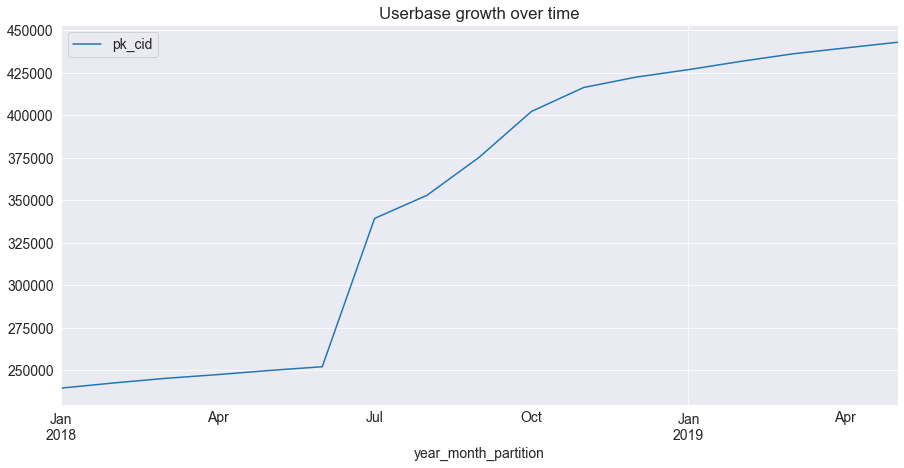

In [127]:
client_subset=pd.DataFrame(df['year_month_partition'].value_counts().sort_values(ascending=True))
client_subset.columns=['Total_Customers']

display(client_subset.T.style.background_gradient(axis=1))
print()
df.groupby("year_month_partition").agg({"pk_cid": "count"}).plot(figsize = (15, 7), title = "Userbase growth over time");

<font color=green><b>Comments</b></font>:

From above graph it can be seen that the above seen seasons for customer acquisition have been successful not only at attracting new customers but also at keeping them.

Let's have a look at both graphs together, customer acquisition and retention from the first moment that we have both dates:

<font color=green><b>New customers from 2018 to 2019-05</b></font>:

,Reporting_Month,New_Customers
0,2018-01,2178
1,2018-02,2509
2,2018-03,2186
3,2018-04,1903
4,2018-05,1995
5,2018-06,1872
6,2018-07,16708
7,2018-08,14378
8,2018-09,23180
9,2018-10,27985


<AxesSubplot:title={'center':'New customers over time'}, xlabel='Reporting_Month'>

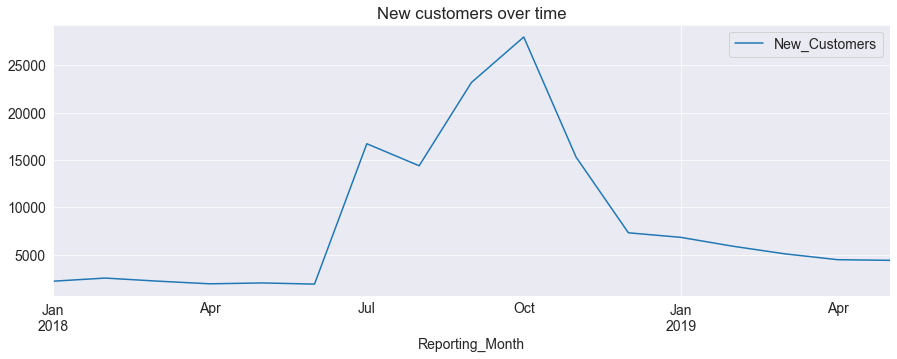

In [128]:
# summary table of new customers per month
first_time_purchase_per_month = df[df['year_month_entry'] == df['year_month_partition']].groupby('year_month_partition')['pk_cid'].nunique().reset_index()
first_time_purchase_per_month.columns = ['Reporting_Month', 'New_Customers']

display(first_time_purchase_per_month)

first_time_purchase_per_month.groupby("Reporting_Month").agg({"New_Customers": "sum"}).plot(figsize = (15, 5), title =  "New customers over time")



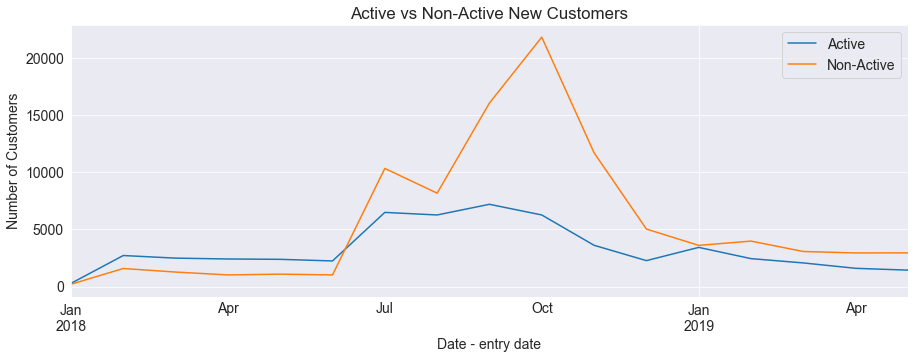

In [129]:
df_check_entries = df.loc[df['entry_date']>='2018-01-28']
df_check_entries.set_index('entry_date', inplace=True)
df_check_entries.drop_duplicates('pk_cid', inplace=True)

plt.subplots(figsize=(15, 5))
df_check_entries.resample('M')['active_customer'].sum().plot()
df_non_active_entry = df_check_entries[df_check_entries['active_customer']==0]
df_non_active_entry.resample('M')['active_customer'].count().plot()

plt.xlabel('Date - entry date')
plt.ylabel('Number of Customers')
plt.title('Active vs Non-Active New Customers')
plt.legend(['Active', 'Non-Active'])
plt.show()

<font color=green><b>Comments</b></font>:

Major flood of new customers reported in the provided partition from Jun-2018 to Nov-2018. In line with the information already reported above. 

The number of non-active is too high for the expectations. These customers have joined easyMoney but show little or no interest on what easyMoney is offering. 

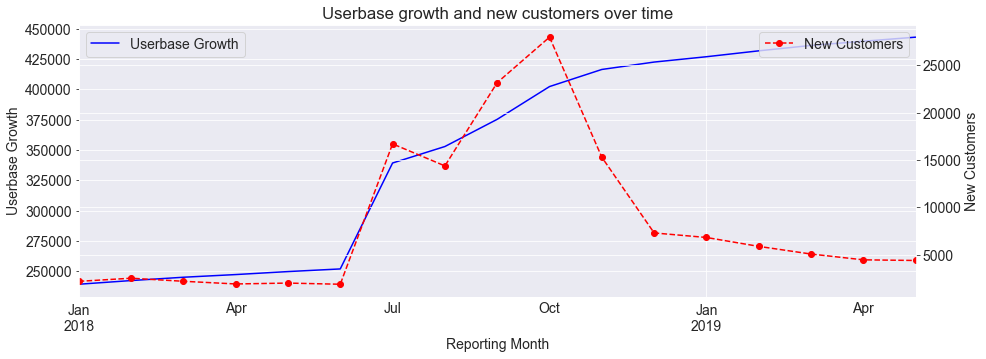

In [130]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot userbase growth
df.groupby("year_month_partition").agg({"pk_cid": "count"}).plot(ax=ax1, legend=False, color='blue')
ax1.set_xlabel('Reporting Month')
ax1.set_ylabel('Userbase Growth')
ax1.set_title('Userbase growth and new customers over time')

ax2 = ax1.twinx()

# Plot new customers per month
first_time_purchase_per_month.groupby("Reporting_Month").agg({"New_Customers": "sum"}).plot(ax=ax2, legend=False, color='red', linestyle='--', marker='o')
ax2.set_ylabel('New Customers')

ax1.legend(['Userbase Growth'], loc='upper left')
ax2.legend(['New Customers'], loc='upper right')

plt.show()


<font color=green><b>Comments</b></font>:

The graph provides insight into customer retention, showing a consistent pattern of low customer acquisition rates in the early part of each year followed by a gradual increase leading up to a peak in Q3-Q4, before dropping off again. The blue line representing user base growth suggests that a significant proportion of customers who joined during this period continued to use the company's services, at least until the end of the available records. However, it would be beneficial to have data on the company's activity since its inception to gain a more comprehensive understanding of the performance of various waves of new registrations.

<font color=green><b>Total Active Customers By month</b></font>

In [131]:
client_subset_active = pd.DataFrame(df[df['active_customer'] == 1]['year_month_partition'].value_counts().sort_values(ascending=True))
client_subset_active.columns = ['Total_Active_Customers']
client_subset_active['Percentage_of_Total_Customers'] = round((client_subset_active['Total_Active_Customers'] / df['year_month_partition'].value_counts() )* 100,2)
display(client_subset_active.T.style.background_gradient(axis=1))

,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
Total_Active_Customers,108211.000000,111085.000000,113806.000000,116318.000000,119066.000000,121560.000000,129287.000000,136350.000000,144787.000000,151962.000000,156321.000000,159235.000000,162545.000000,165067.000000,168185.000000,169998.000000,171568.000000
Percentage_of_Total_Customers,45.180000,45.800000,46.400000,47.000000,47.640000,48.220000,38.100000,38.630000,38.580000,37.770000,37.540000,37.690000,38.080000,38.230000,38.560000,38.670000,38.730000


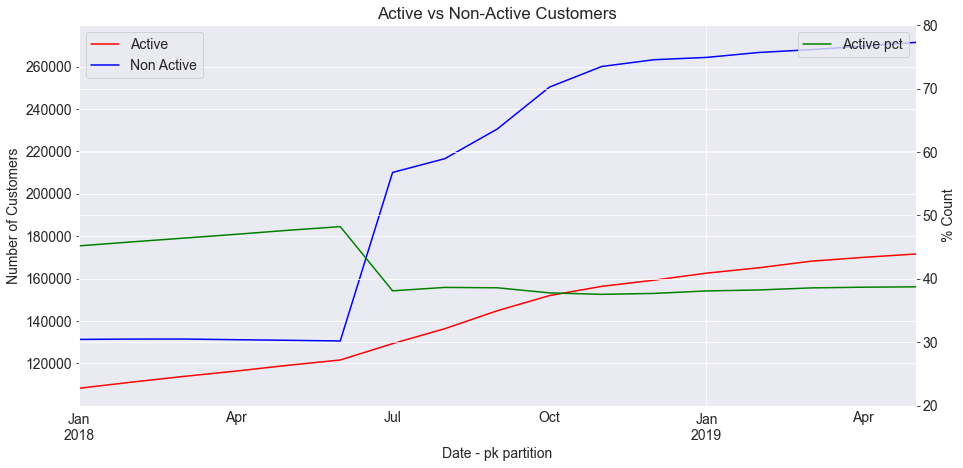

In [132]:
df_2=df.copy()
df_2.set_index('pk_partition', inplace=True)


fig, ax1 = plt.subplots(figsize=(15, 7))

df_2.resample('M')['active_customer'].sum().plot(ax=ax1, color='red', label='Active')
df_non_active = df_2[df_2['active_customer']==0]
df_non_active.resample('M')['active_customer'].count().plot(ax=ax1, color='blue', label='Non Active')

ax2 = ax1.twinx()

active_pct = df_2.resample('M')['active_customer'].sum()/df_2.resample('M')['active_customer'].count()*100
active_pct.plot(ax=ax2, color='green', label='Active pct')
ax2.set_ylim([20, 80]) 

ax1.set_title('Active vs Non-Active Customers')
ax1.set_xlabel('Date - pk partition')
ax1.set_ylabel('Number of Customers')
ax2.set_ylabel('% Count')

# display legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


<font color=green><b>Comments</b></font>:

The first thing that can be noticed is the sharp decrease, of around a 10%, of active customers from June to July 2018. According to previously analyzed information, this specific period was very successful in terms of client acquisitions (entry date), meaning that during July 2018 a great amount of customers registered with easyMoney but the total percentage of users that actually interacted with it decreased. From that point on, it remains relatively stable, but it never goes up closer to previous values.

A clear conclusion is that even though the absolute number of users that are active in the application is steadily increasing, the overall engagement of the current client base with the application is stagnated and is lower than in previous periods. Have any changes in the app occurred during the mentioned key periods?

This graph and the active rate in % could be use in the future to monitor the business overall

<font color=green><b>Number of Months a customer is reported</b></font>

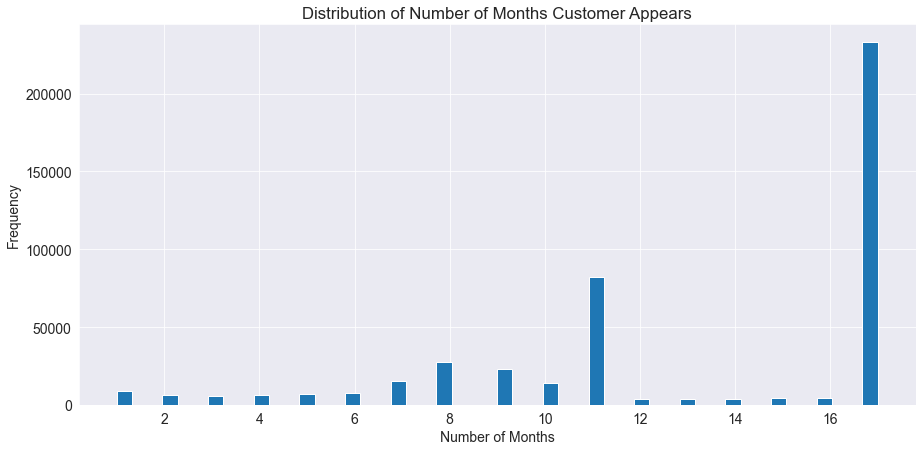

In [133]:
counts_by_customer = df.groupby(['pk_cid'])['year_month_partition'].nunique().sort_values(ascending=False)

plt.subplots(figsize=(15, 7))
plt.hist(counts_by_customer, bins=50)

plt.title("Distribution of Number of Months Customer Appears")
plt.xlabel("Number of Months")
plt.ylabel("Frequency")

plt.show()

In [134]:
counts_by_customer=counts_by_customer.reset_index()
print("Number of customers below 17 partitions:", (counts_by_customer['year_month_partition'] < 17).sum())
print("Number of customers with 17 partitions:", (counts_by_customer['year_month_partition']== 17).sum())

Number of customers below 17 partitions: 223399
Number of customers with 17 partitions: 232974


<font color=green><b>Comments</b></font>

The data seems not to be complete, it misses partitions of certain customers

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Country id]</b></font>

In [135]:
display(df['country_id'].value_counts().head(10))

ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
Name: country_id, dtype: int64

<font color=green><b>Comments</b></font>

The majority of customers are from **Spain (5,960,672)**. The other countries have much lower numbers of customers, with the United Kingdom having the second-highest number (441), followed by France (225), Germany (199)

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Region code]</b></font>

In [136]:
# Fill na with 999
df['region_code'].fillna(999, inplace=True)

In [137]:
# update region codes with the actual region names

regions={1:'Alava',2:'Albacete',3:'Alicante',4:'Almeria',5:'Avila',6:'Badajoz',7:'Baleares',
8:'Barcelona',9:'Burgos',10:'Caceres',11:'Cadiz',12:'Castellon',13:'Ciudad Real',14:'Cordoba',
15:'La Coruna',16:'Cuenca',17:'Gerona',18:'Granada',19:'Guadalajara',20:'Guipuzcoa',21:'Huelva',
22:'Huesca',23:'Jaen',24:'Leon',25:'Lerida',26:'La Rioja',27:'Lugo',28:'Madrid',29:'Malaga',
30:'Murcia',31:'Navarra',32:'Orense',33:'Asturias',34:'Palencia',35:'Las Palmas',36:'Pontevedra',
37:'Salamanca',38:'Santa Cruz de Tenerife',39:'Cantabria',40:'Segovia',41:'Sevilla',42:'Soria',
43:'Tarragona',44:'Teruel',45:'Toledo',46:'Valencia',47:'Valladolid',48:'Vizcaya',49:'Zamora',
50:'Zaragoza',51:'Ceuta',52:'Melilla',999:'Not_available'}

df['region_code']=df['region_code'].map(regions)

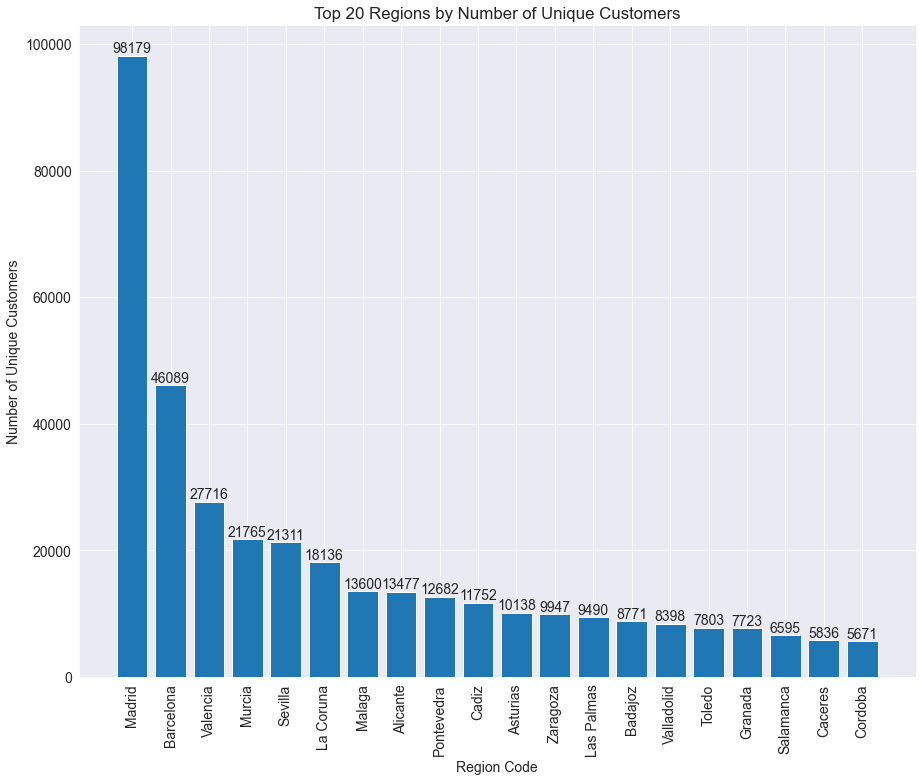

In [138]:
region_counts = df.groupby('pk_cid')['region_code'].first().value_counts().head(20)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)
bars = ax.bar(region_counts.index, region_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Region Code')
plt.ylabel('Number of Unique Customers')
plt.title('Top 20 Regions by Number of Unique Customers')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
plt.show()

<font color=green><b>Comments</b></font>

Most of the customers are registered in Madrid, Barcelona and Valencia

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Gender]</b></font>

In [139]:
counts_gender=df.groupby(['pk_cid'])['gender'].nunique().sort_values(ascending=False).reset_index()
counts_gender

,pk_cid,gender
0,1245873,2
1,1408146,2
2,1406504,2
3,1409684,2
4,1404082,2
...,...,...
456368,1188532,1
456369,1188531,1
456370,1553689,1
456371,216507,0


In [140]:
# Print the result
print("Number of customers with 2 genders:", (counts_gender['gender'] ==2).sum())
print("Number of customers with 0 genders:", (counts_gender['gender'] == 0).sum())


Number of customers with 2 genders: 41
Number of customers with 0 genders: 2


<font color=green><b>Comments</b></font>

There 41 customers with two genders. This is needs to be corrected. Also, to be communicated to the team to correct the data at the source. 

In [141]:
gender_counts_2 = counts_gender[counts_gender['gender'] == 2]

customers_gender_2_dict = {}
for pk_cid in gender_counts_2['pk_cid'].tolist():
    gender_values = df[df['pk_cid'] == pk_cid]['gender'].dropna().unique().tolist()
    customers_gender_2_dict[pk_cid] = gender_values

cust_double_gender_list = list(customers_gender_2_dict.keys())

In [142]:
# Filter the df 
filtered_df = df[df['pk_cid'].isin(cust_double_gender_list)]

# Sort the filtered dataframe to ensure the latest report for each customer is last
filtered_df = filtered_df.sort_values(by=['pk_cid', 'pk_partition'])

# Create a dictionary with the latest reported gender for each customer

latest_gender = {}
for customer in cust_double_gender_list:
    gender = filtered_df[filtered_df['pk_cid'] == customer]['gender'].iloc[-1]
    latest_gender[customer] = gender

In [143]:
for customer, gender in latest_gender.items():
    df.loc[df['pk_cid'] == customer, 'gender'] = gender

In [144]:
# fill na
df['gender'].fillna(99, inplace=True)

assert df['gender'].isna().sum() == 0

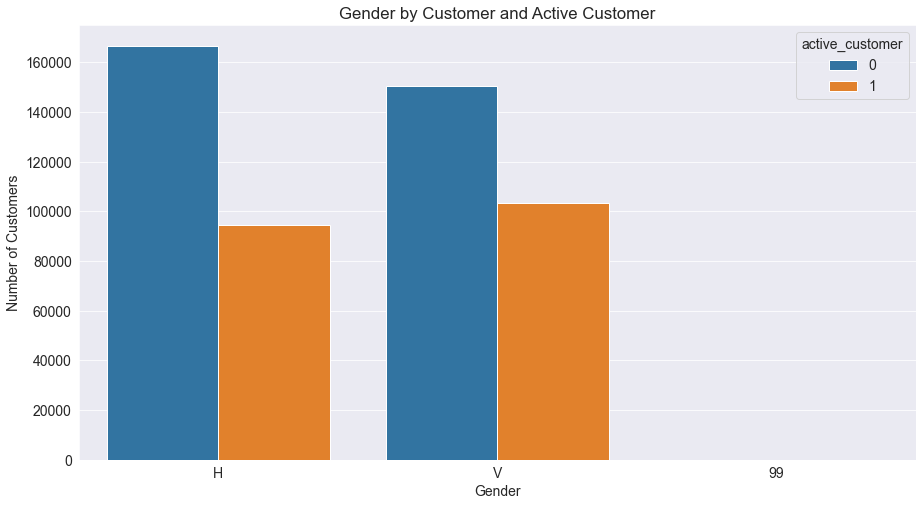

In [145]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 8))

gender = df.groupby(['pk_cid', 'active_customer'])['gender'].last().reset_index()
sns.countplot(x='gender', data=gender, hue='active_customer')
plt.title('Gender by Customer and Active Customer')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')

plt.show()


<font color=green><b>Comments</b></font>

The dataset contains instances where customers reported different genders at different times. To correct for this, we replaced these instances with the latest reported gender for each customer. Missing gender values were replaced with 99 to indicate that these values are not available.

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">


<font color=green size=+2><b> [Age]</b></font>

In [146]:
count_ages=df.groupby('pk_cid')['age'].nunique().sort_values(ascending=False).reset_index()
count_ages.head(10)

,pk_cid,age
0,1519642,4
1,1519143,4
2,1427987,3
3,1439833,3
4,1497191,3
5,1438607,3
6,1440910,3
7,1308540,3
8,794611,3
9,1409179,3


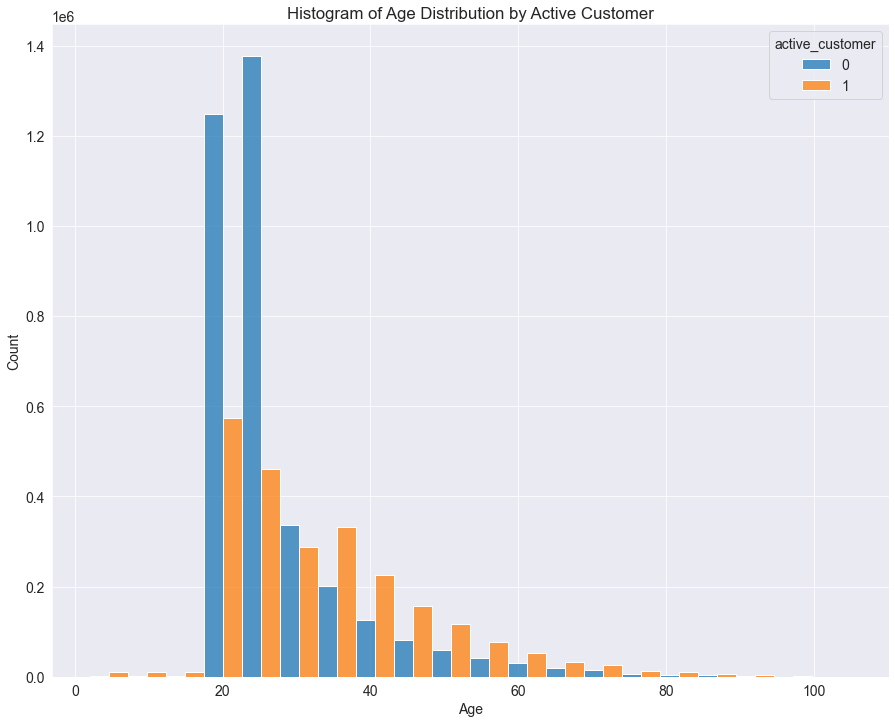

In [147]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.histplot(data=df, x='age', bins=20, hue='active_customer', multiple='dodge')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age Distribution by Active Customer')
plt.show()

In [148]:
# Print the result
print("Number of customers with 4 ages:", (count_ages['age'] ==4).sum())
print("Number of customers with 3 ages:", (count_ages['age'] == 3).sum())
print("Number of customers with 2 ages:", (count_ages['age'] == 2).sum())
print("Number of customers with 1 ages:", (count_ages['age'] == 1).sum())
print("Number of customers with 0 ages:", (count_ages['age'] == 0).sum())

Number of customers with 4 ages: 2
Number of customers with 3 ages: 172
Number of customers with 2 ages: 341568
Number of customers with 1 ages: 114631
Number of customers with 0 ages: 0


In [149]:
count_ages_more1=count_ages[count_ages['age']>=0]
list_age=count_ages_more1['pk_cid'].unique().tolist()

# Create a dictionary with the latest reported age for each customer
latest_age = df.groupby('pk_cid')['age'].max().to_dict()

# update all ages based on the latest reported age
df['age'] = df['pk_cid'].map(latest_age)

<font color=green><b>Age under 18 analysis</b></font>

In [150]:
df_age_under18=df[df['age']<18]
len(df_age_under18['pk_cid'].unique())

2706

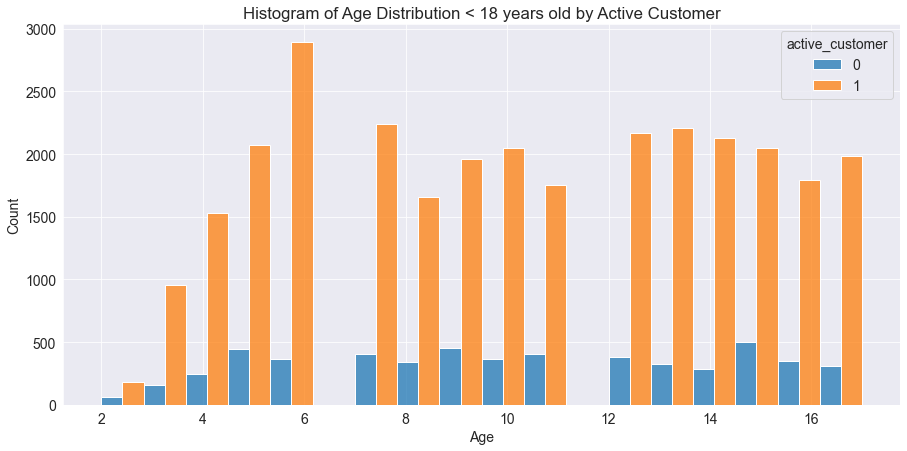

In [151]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.histplot(data=df_age_under18, x='age', bins=18, hue='active_customer', multiple='dodge')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age Distribution < 18 years old by Active Customer')
plt.show()

In [152]:
df_age_under18[products].describe().T

,count,mean,std,min,25%,50%,75%,max
short_term_deposit,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loans,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mortgage,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
funds,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
securities,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
long_term_deposit,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
credit_card,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
debit_card,35025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
payroll,35025.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00
pension_plan,35025.00,0.01,0.07,0.00,0.00,0.00,0.00,1.00


In [153]:
# drop rows where ages are below 18
drop_under18 = df[df['age'] < 18]['pk_cid'].unique()
print(f"Shape of the dataframe before dropping under 18 customers: {df.shape}")

df.drop(df[df['pk_cid'].isin(drop_under18)].index, inplace=True)

df.reset_index(drop=True, inplace=True)
print(f"Shape of the dataframe after dropping under 18 customers: {df.shape}")


Shape of the dataframe before dropping under 18 customers: (5962924, 33)
Shape of the dataframe after dropping under 18 customers: (5927899, 33)


In [154]:
df['age'].describe()

count   5927899.00
mean         30.39
std          11.90
min          18.00
25%          23.00
50%          25.00
75%          35.00
max         105.00
Name: age, dtype: float64

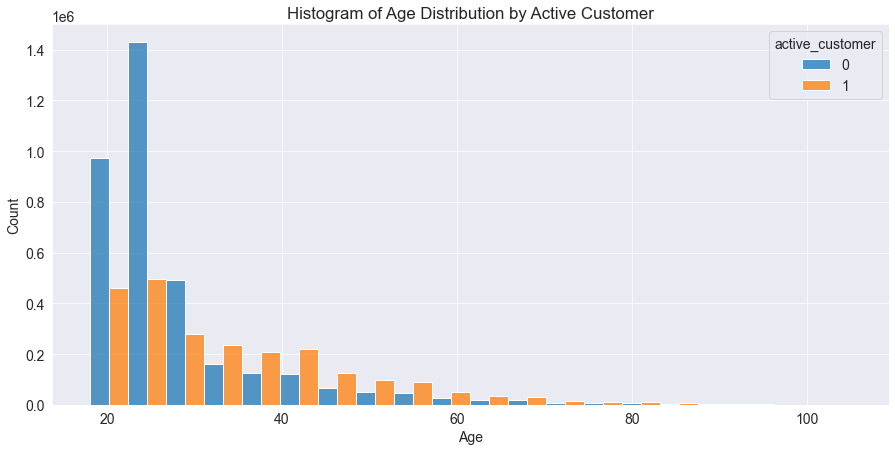

In [155]:
fig, ax = plt.subplots(figsize=(15, 7))

sns.histplot(data=df, x='age', bins=20, hue='active_customer', multiple='dodge')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age Distribution by Active Customer')
plt.show()

<font color=green><b>Comments</b></font>

The age feature in the dataset was found to have inconsistencies, such as customers with multiple ages. To address this issue, a strategy was implemented to ensure that all customers had a consistent age value, which was set to the latest known age for each customer. 
This approach aims to improve the accuracy and consistency of our data analysis, but it is important to note that there may be alternative methods for addressing inconsistencies in the age feature, depending on the specific goals and context of the analysis.

In Europe, the minimum age to open and manage a bank account varies by country, but generally ranges from 16 to 18 years old. In the provided dataset, there are 2706 customers who are under the minimum age, with ages ranging from 2 to 17 years old. It is observed that these customers have very limited product holdings, usually restricted to only an em account, payroll or pension plan, and that only a few them have these products.

As a result, all customers below the age of 18 were removed from the dataset as they do not provide meaningful information in the context of our analysis, and are not relevant targets for our recommendations.


<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Deceased]</b></font>

In [156]:
df.groupby('deceased')['active_customer'].value_counts()

deceased  active_customer
N         0                  3551812
          1                  2375012
S         1                      718
          0                      357
Name: active_customer, dtype: int64

718 instances of active deceased customer

In [157]:
count_deceased=df.groupby('pk_cid')['deceased'].nunique().sort_values(ascending=False).reset_index()
display(count_deceased.head(10))

,pk_cid,deceased
0,1141137,2
1,1018341,2
2,1326404,2
3,1114671,2
4,1120228,2
5,1027532,2
6,1120236,2
7,1371308,2
8,1406450,2
9,1268627,2


In [158]:
# delete all customers that deceased during the partition
deceased_customers = df[df['deceased'] == 'S']
customer_ids_to_delete = deceased_customers['pk_cid'].tolist()

df = df[~df['pk_cid'].isin(customer_ids_to_delete)]

# check
print(df['deceased'].unique())

['N']


<font color=green><b>Comments</b></font>

The data contains information on customers who have passed away during a specific period, but their accounts have remained active with their products. 

All deceased customers are removed


<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Salary]</b></font>

In [159]:
count_salary=df.groupby('pk_cid')['salary'].nunique().sort_values(ascending=False).reset_index()
count_salary.head(10)

,pk_cid,salary
0,1284935,1
1,1261501,1
2,1261496,1
3,1261495,1
4,1261492,1
5,1261491,1
6,1261490,1
7,1261489,1
8,1261487,1
9,1261486,1


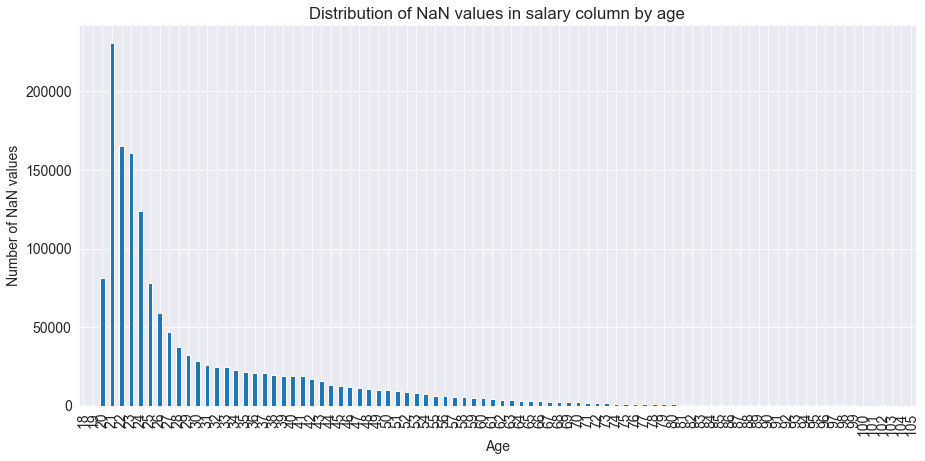

In [160]:
# Distribution of Nan values per age
df.groupby('age')['salary'].apply(lambda x: x.isnull().sum()).plot(kind='bar', figsize=(15,7))
plt.xlabel('Age')
plt.ylabel('Number of NaN values')
plt.title('Distribution of NaN values in salary column by age')
plt.show()

In [161]:
# Replace NaN values in salary column with median salary for each age group

median_salary_by_age = df.groupby('age')['salary'].median()
df['salary'] = np.where(df['salary'].isnull(), df['age'].map(median_salary_by_age), df['salary'])


In [162]:
outliers(df[['salary']])

df["salary"]
Min: 1202.73, Max: 28894395.51, Q1: 70085.61, Q3: 113275.68
IQR: 43190.06999999999
LOWER/UPPER Range: 5300.505000000012 / 178060.78499999997
Total LOWER/UPPER outliers: 94 / 568933



In [163]:
df[['salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
salary,5926063.00,108774.32,173168.69,1202.73,70085.61,88322.97,113275.68,28894395.51


In [164]:
len(df[df['salary']>1000000]['pk_cid'].unique())

583

In [165]:
# New column called salary_LN which contains the natural logarithm (base e) of the values in the salary column.
df["salary_LN"] = df["salary"].apply(lambda x: np.log1p(x))

In [166]:
df[['salary','salary_LN']].describe()

,salary,salary_LN
count,5926063.00,5926063.00
mean,108774.32,11.42
std,173168.69,0.53
min,1202.73,7.09
25%,70085.61,11.16
50%,88322.97,11.39
75%,113275.68,11.64
max,28894395.51,17.18


<font color=green><b>Comments</b></font>

To address outliers in the salary feature of the dataset, a log transformation was applied to convert it into a normal distribution. Additionally, missing values in the salary feature were imputed by using the median of the age distribution, assuming age as a good predictor of salary.

However, due to the intrinsic limitations and characteristics of this feature, such as a significant number of missing values, it will not be utilized in further steps such as segmentation or recommendation

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Entry_Channel]</b></font>

In [167]:
df.groupby('entry_channel')['pk_cid'].nunique().sort_values(ascending=False).head(10)

entry_channel
KHE    196699
KHQ     76369
KFC     58941
KHM     32894
KAT     26535
KHN     17423
KHK     17219
RED      5278
KHD      4865
KFA      4466
Name: pk_cid, dtype: int64

In [168]:
#Check Missing values
missing_values(df[['entry_channel']])

,Missing_Number,Percentage %
entry_channel,132281,2.23


In [169]:
# Fill NaN values
fillna_ffill(df,'entry_channel').head(1)

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,short_term_deposit,loans,...,entry_channel,active_customer,segment,Total_products,year_partition,month_partition,year_month_partition,quarter_entry,year_month_entry,salary_LN
0,1375586,2018-01-28,ES,Malaga,H,36,N,87218.10,0,0,...,KHL,1,02 - PARTICULARES,1.00,2018,1,2018-01,2018-Q1,2018-01,11.38


In [170]:
# check if entry channel is unique for every customer
count_entry=df.groupby('pk_cid')['entry_channel'].nunique().sort_values(ascending=False).reset_index()
count_entry.head(10)

,pk_cid,entry_channel
0,1263084,4
1,1440196,3
2,1514711,3
3,1436198,3
4,1508637,3
5,1489074,3
6,1383262,3
7,1267380,3
8,1499720,3
9,1437523,3


In [171]:
# How many duplications?
count_entries3=count_entry[count_entry['entry_channel']>1]
list_entry=count_entries3['pk_cid'].unique().tolist()
len(list_entry)

9142

In [172]:
# Vizualize one specific customer
df[df['pk_cid']==random.choice(list_entry)].T

,3856149,4354042,4701056,5061929,5654711
pk_cid,1522112,1522112,1522112,1522112,1522112
pk_partition,2019-01-28 00:00:00,2019-02-28 00:00:00,2019-03-28 00:00:00,2019-04-28 00:00:00,2019-05-28 00:00:00
country_id,ES,ES,ES,ES,ES
region_code,Zaragoza,Zaragoza,Zaragoza,Zaragoza,Zaragoza
gender,V,V,V,V,V
age,34,34,34,34,34
deceased,N,N,N,N,N
salary,84181.65,84181.65,84181.65,84181.65,84181.65
short_term_deposit,0,0,0,0,0
loans,0,0,0,0,0


In [173]:
filtered_df = df[df['pk_cid'].isin(list_entry)]

# Sort the filtered dataframe
filtered_df = filtered_df.sort_values(by=['pk_cid', 'pk_partition'])

# Create a dictionary with the latest reported entry channel for each customer
latest_entry = {}
for customer in list_entry:
    entry = filtered_df[filtered_df['pk_cid'] == customer]['entry_channel'].iloc[-1]
    latest_entry[customer] = entry


In [174]:
entry_map = pd.Series(latest_entry)
# Use boolean indexing to update the entry_channel column in df
df.loc[df['pk_cid'].isin(entry_map.index), 'entry_channel'] = entry_map

In [175]:
top_10_channels = df['entry_channel'].value_counts().nlargest(10).index.tolist()

# Replace values not in top 7 with 'others'
df.loc[~df['entry_channel'].isin(top_10_channels), 'entry_channel'] = 'others'

<AxesSubplot:xlabel='entry_channel', ylabel='count'>

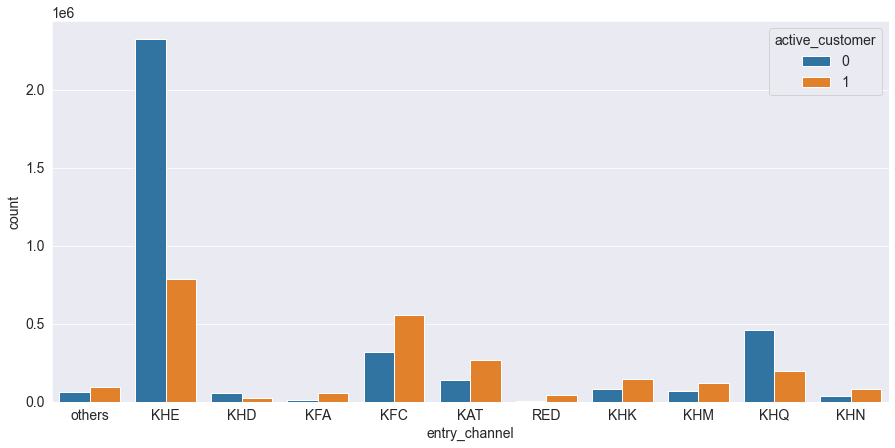

In [176]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 7))
sns.countplot(x='entry_channel', hue='active_customer', data=df)

In [177]:
ct_by_channel_active = (pd.crosstab(df['entry_channel'], df['active_customer'])
                       .astype(int)
                       .apply(lambda x: x / x.sum() * 100, axis=1)
                       .round(decimals=2)
                       .reindex(columns=df['active_customer'].unique()))

ct_by_channel_active.sort_values(by=1.00,ascending=False)

active_customer,1,0
entry_channel,,
RED,86.73,13.27
KFA,85.90,14.10
KHN,70.89,29.11
KAT,66.32,33.68
KHK,63.90,36.10
KFC,63.62,36.38
KHM,62.92,37.08
others,61.47,38.53
KHQ,30.19,69.81


<font color=green><b>Comments</b></font>

The customer acquisition channel represents the methods or platforms utilized by a business to acquire new customers. It involves attracting potential customers to a business or product.

The dataset contained numerous missing values. To address this, the missing values were filled using the forward-filling method. Moreover, data was corrected to account for instances where a single customer had multiple reported channels by considering only the latest reported channel.

In the analysis, only the top 10 channels were considered, while the rest were categorized as 'others' and disregarded. It was observed that certain channels were more effective in acquiring customers compared to others. Furthermore, it was noted that some channels resulted in customers who were less active. 

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Products]</b></font>

In [178]:
grouped_sum = df.groupby('pk_partition')['Total_products'].sum()
group_mean=df.groupby('pk_partition')['Total_products'].mean()

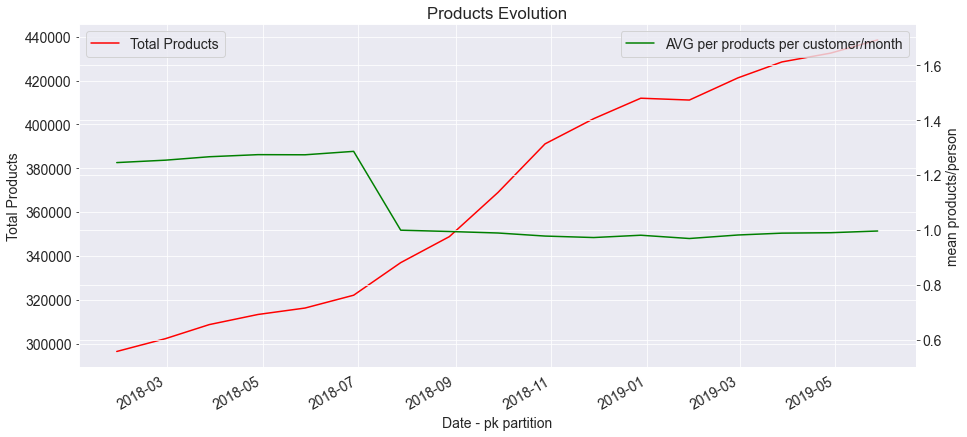

In [179]:
fig, ax1 = plt.subplots(figsize=(15, 7))

grouped_sum.plot(ax=ax1, color='red', label='Total Products')

ax2 = ax1.twinx()

group_mean.plot(ax=ax2, color='green', label='AVG per products per customer/month')

ax2.set_ylim([0.5, 1.75]) 

ax1.set_title('Products Evolution')
ax1.set_xlabel('Date - pk partition')
ax1.set_ylabel('Total Products')
ax2.set_ylabel('mean products/person')

# display legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [180]:
print( "the AVG product per customer in 2019 is: ",df[df['year_partition']>2018].groupby('pk_partition')['Total_products'].mean().mean())

the AVG product per customer in 2019 is:  0.9849995958350315


<font color=green><b>Comments</b></font>

Although the number of customers keep in increasing the average products per customers drops sharply and in 2019 the average is below 1. 

<font color=green><b>2019-05: Total products per customer</b></font>

In [181]:
df_2019_05=df[df['year_month_partition']=='2019-05']

total_products = df_2019_05["Total_products"].value_counts().to_frame().reset_index()
total_products.columns = ["nr_products", "nr_customers"]
total_products.sort_values("nr_products", ascending = True, inplace = True)
total_products["pct_over_total"] = total_products["nr_customers"]/total_products["nr_customers"].sum()
total_products.head()

,nr_products,nr_customers,pct_over_total
1,0.00,108751,0.25
0,1.00,268226,0.61
2,2.00,38690,0.09
3,3.00,11496,0.03
4,4.00,8478,0.02


In [182]:
total_products_active = df_2019_05[df_2019_05['active_customer']==1]["Total_products"].value_counts().to_frame().reset_index()
total_products_active.columns = ["nr_products", "nr_customers"]
total_products_active.sort_values("nr_products", ascending = True, inplace = True)
total_products_active["pct_over_total"] = total_products_active["nr_customers"]/total_products_active["nr_customers"].sum()
total_products_active.head()

,nr_products,nr_customers,pct_over_total
5,0.00,2769,0.02
0,1.00,104187,0.62
1,2.00,37861,0.22
2,3.00,11473,0.07
3,4.00,8477,0.05


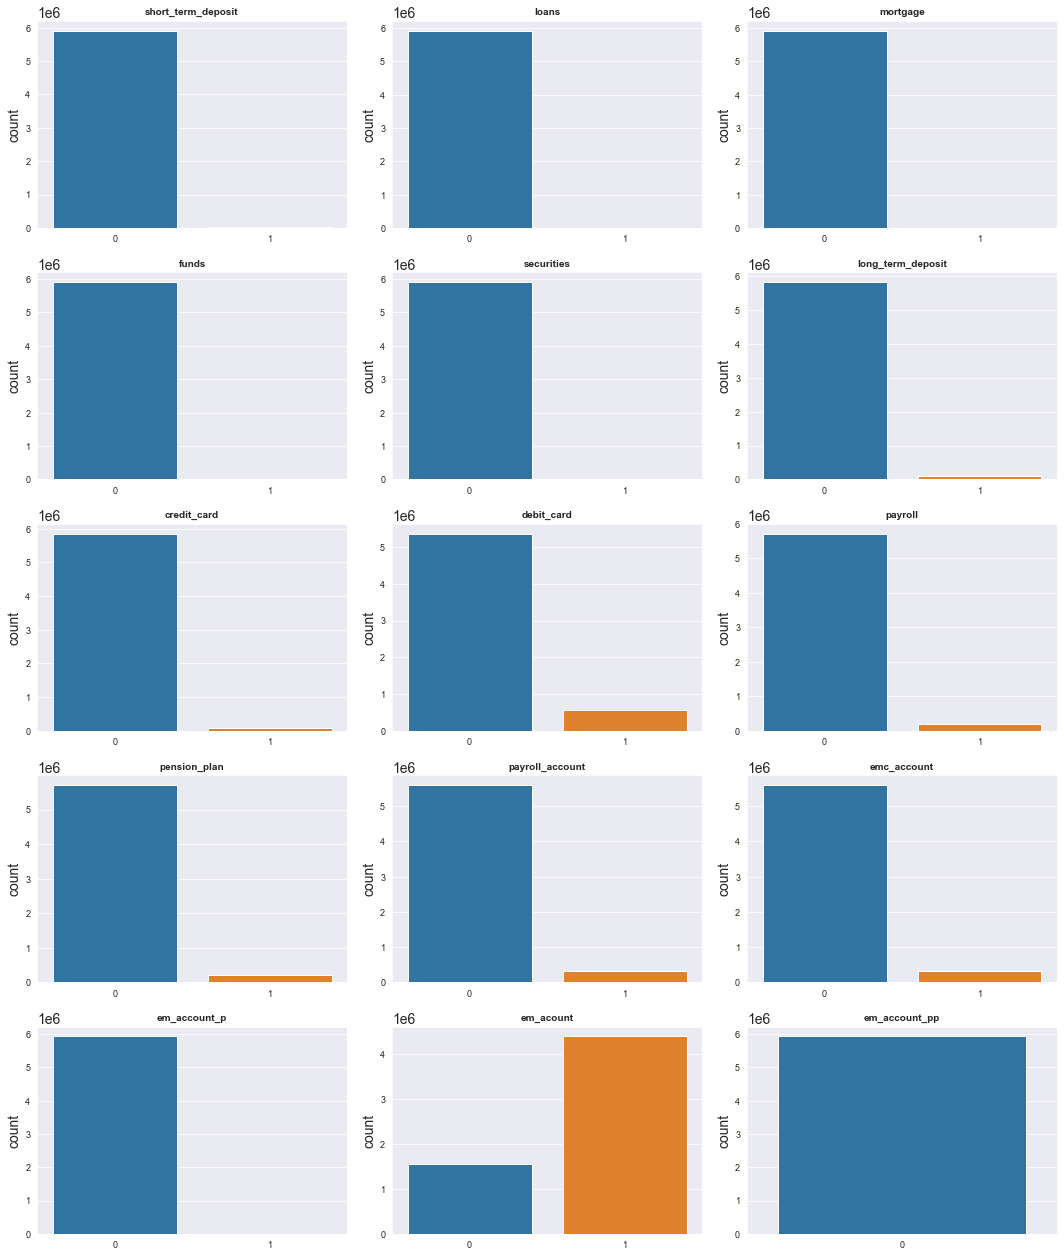

In [183]:
bool_feat = [col for col in products if (df[col].dtype != 'O') and (col != 'pk_cid')]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 18))
axes = axes.flat

for i, col in enumerate(bool_feat):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].tick_params(labelsize=9)
    axes[i].set_xlabel("")

fig.tight_layout()
fig.subplots_adjust(top=0.96)

<font color=green><b>Comments</b></font>

The graph highlights the distribution of products within a dataset, and it's evident that there is an imbalance in product popularity. The majority of customers have opted for the Em_account, making it the primary product. The remaining products, seem to fall into the secondary tier category, with significantly fewer users.

In [184]:
# Product portfolio ranking 
prod_summary = pd.DataFrame(df[products].sum()).reset_index()
prod_summary.columns = ['Product', 'Count_Purchased']

prod_summary['Percentage'] = prod_summary['Count_Purchased'] / len(df) * 100

prod_summary = prod_summary[prod_summary['Count_Purchased'] > 0]
prod_summary = prod_summary.sort_values(by='Percentage', ascending=False)

display(prod_summary)

,Product,Count_Purchased,Percentage
13,em_acount,4380564,73.92
7,debit_card,562532,9.49
10,payroll_account,329076,5.55
11,emc_account,326441,5.51
9,pension_plan,217439,3.67
8,payroll,205721,3.47
5,long_term_deposit,100291,1.69
6,credit_card,70813,1.19
4,securities,22042,0.37
3,funds,20069,0.34


<font color=green><b>Comments</b></font>

The table presents the same data as the previously discussed bar plot but in a more easily understandable format. The data indicates that approximately 74% of the customers or partitions have either held or currently hold an em account. The debit card, payroll and payroll account, emc account, and pension plan also have customer representation, but to a lesser extent. Interestingly, the only product that does not have any customer representation is the em account pp.

Text(0.5, 0.98, 'Monthly evolution of product features')

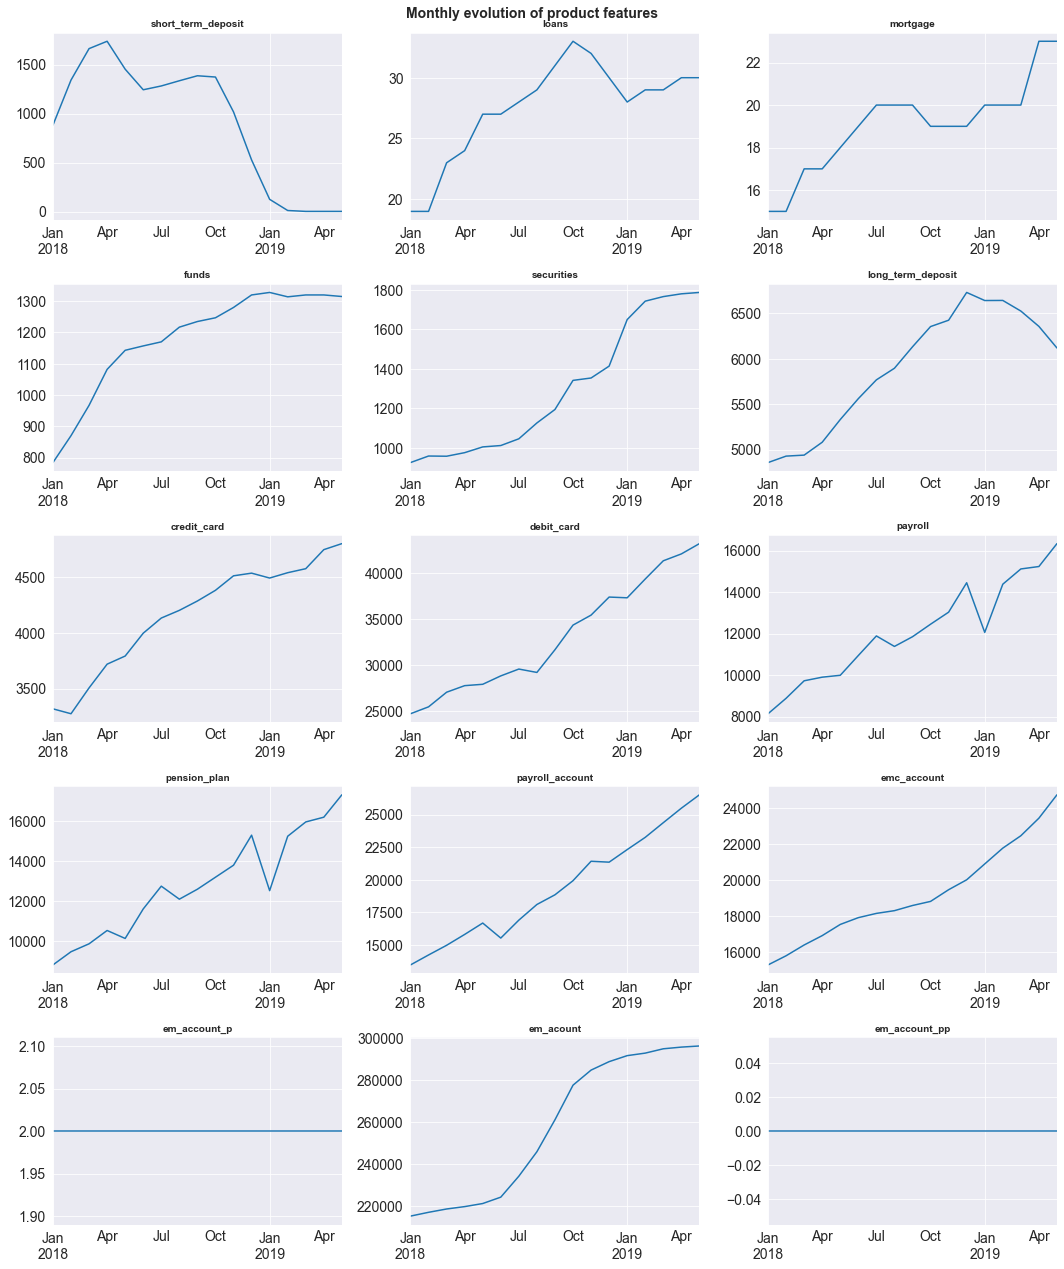

In [185]:
# Products Evolution
products_df_bydate = df.set_index('pk_partition')

fig, axes = plt.subplots(nrows=5, ncols=3, figsize =(15,18))
axes = axes.flat

for i, col in enumerate(bool_feat):
    products_df_bydate.resample('M')[col].sum().plot(ax = axes[i])
    axes[i].set_title(col, fontsize = 10, fontweight = 'bold')
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top = 0.96)
fig.suptitle('Monthly evolution of product features', fontsize = 14, fontweight = 'bold')

<font color=green><b>Comments</b></font>

The data analysis reveals several interesting trends and patterns in the performance of the company's various products over time. Short-term deposits began well but have dwindled to zero, indicating poor retention over time. Loans and mortgages have few customers relative to the company's customer base but have shown good retention. However, it is important to assess the revenue generated by these products to determine their profitability. Funds and securities have a stable customer base but not many customers. Long-term deposits have sharply decreased. 

The EM account is the most popular product in terms of customer base and retention, while the EM account_p and EM account_pp have very few or none customers. The rest of the products have different customer bases and show good growth.

The payroll account, which is awarded as a bonus for payroll, has more users than the payroll itself, which seems illogical.

In summary, the data reveals both strengths and weaknesses in the company's product offerings. While some products may be underperforming or unsuitable, others show promise for future growth. 

The company may benefit from reevaluating its current product lineup to optimize its offerings and capitalize on market opportunities.

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> [Remaining Features]</b></font>

<font color=green size=+1><b> Activity Customer</b></font>

The "Active Customer" feature is a crucial metric that provides insight into a customer's level of engagement with the company's platform. It allows us to assess their overall behavior and activity within our ecosystem, it has been used as an indicator while studying some of the other features and won't be studied on its own.

<font color=green size=+1><b> Segment</b></font>

Regarding the last remaining feature. "Segment", it will be disregarded from this point on as it appears to be an incomplete attempt to segment the customer base. Instead, a different way of segmenting the customer base will be suggested, using more robust methodologies to accurately segment and understand our customer base. This will enable to tailor our products and services to better meet the needs and preferences of each customer segment, thereby driving growth and retention.

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+3><b>2.4 - Save Dataset</b></font>

In order to prepare the dataframe for segmentation and recommendation phases, several features have been engineered and some customers have been removed from the working dataframe as they add no value in further analysis or potential use for a Machine Learning model.

The final step before saving the dataframe as a CSV that can be used for other purposes is to remove the features that will have no use or add any value during the segmentation and recommendation phases. This includes the "deceased" feature, as well as the "em_account_pp", "em_account_p", and "segment" features, which have already been engineered or are not relevant for the current analysis.

By removing these features, the dataframe will be streamlined and better suited for segmentation and recommendation purposes. The resulting CSV file can then be used as a starting point for further analysis, such as building a machine learning model to predict customer behavior or preferences.

In [186]:
list_drop_columns=['deceased','em_account_pp','em_account_p','segment']

In [189]:
products.remove('em_account_p')
products.remove('em_account_pp')

In [187]:
df=df.drop(list_drop_columns, axis=1)

In [190]:
int_cols = df[products].columns
df[int_cols] = df[int_cols].astype('int8')

In [191]:
df.to_csv('Bobs_df_delivery.csv', index=False)

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">


<font color=green size=+3><b>3 - Exploratory Analysis - EDA </b></font>

The main objective of Exploratory Data Analysis (EDA) is to understand the data and gain insights from it, and generally become familiar with the characteristics and limitations of the data.

In this chapter, questions will be asked and answers will be provided with the main conclusions.

<font color=green size=+2><b> What are the top products per entry channel?</b></font>

In [192]:
results_entry=get_best_products(df, 'entry_channel')
results_entry

,entry_channel,best_product,second_best_product,third_best_product
0,others,em_acount,debit_card,payroll_account
1,KHE,em_acount,debit_card,payroll_account
2,KHD,em_acount,debit_card,payroll_account
3,KFA,em_acount,emc_account,debit_card
4,KFC,em_acount,debit_card,emc_account
5,KAT,em_acount,debit_card,emc_account
6,RED,em_acount,debit_card,payroll_account
7,KHK,em_acount,debit_card,payroll_account
8,KHM,em_acount,debit_card,payroll_account
9,KHQ,em_acount,debit_card,payroll_account


In [193]:
print("Unique best products:", results_entry['best_product'].unique())
print("Unique second best products:", results_entry['second_best_product'].unique())
print("Unique third best products:", results_entry['third_best_product'].unique())

Unique best products: ['em_acount']
Unique second best products: ['debit_card' 'emc_account']
Unique third best products: ['payroll_account' 'debit_card' 'emc_account']


<font color=green size=+2><b> What are the top products per region?</b></font>

In [194]:
results_region=get_best_products(df, 'region_code')
results_region

,region_code,best_product,second_best_product,third_best_product
0,Malaga,em_acount,debit_card,payroll_account
1,Ciudad Real,em_acount,debit_card,emc_account
2,Zaragoza,em_acount,debit_card,emc_account
3,Toledo,em_acount,debit_card,payroll_account
4,Leon,em_acount,debit_card,emc_account
5,Guipuzcoa,em_acount,emc_account,debit_card
6,Caceres,em_acount,debit_card,payroll_account
7,Gerona,em_acount,debit_card,payroll_account
8,Zamora,em_acount,debit_card,payroll_account
9,Barcelona,em_acount,debit_card,payroll_account


In [195]:
print("Unique best products:", results_region['best_product'].unique())
print("Unique second best products:", results_region['second_best_product'].unique())
print("Unique third best products:", results_region['third_best_product'].unique())

Unique best products: ['em_acount']
Unique second best products: ['debit_card' 'emc_account']
Unique third best products: ['payroll_account' 'emc_account' 'debit_card']


After analyzing the data, we have found that the main products used by for each region are em_account, debit card, and emc_account. This information is similar to our previous analysis on the entry_channel. 

<font color=green size=+2><b> What are the top products per salary category?</b></font>

In [196]:
import pandas as pd
from sklearn.cluster import KMeans

# Select the numerical salary feature to cluster
X = df['salary'].values.reshape(-1, 1)

# Cluster the data into five groups using KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

# Create a new feature with the cluster group names
df['salary_category'] = kmeans.predict(X)
df['salary_category'] = df['salary_category'].map({0: 'Very Low', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})

In [197]:
results_salary=get_best_products(df, 'salary_category')
results_salary

,salary_category,best_product,second_best_product,third_best_product
0,Very Low,em_acount,debit_card,payroll_account
1,Medium,em_acount,debit_card,emc_account
2,Very High,em_acount,debit_card,payroll_account
3,Low,em_acount,debit_card,emc_account
4,High,em_acount,debit_card,emc_account


In [198]:
print("Unique best products:", results_salary['best_product'].unique())
print("Unique second best products:", results_salary['second_best_product'].unique())
print("Unique third best products:", results_salary['third_best_product'].unique())

Unique best products: ['em_acount']
Unique second best products: ['debit_card']
Unique third best products: ['payroll_account' 'emc_account']


Once again the salary feature does not provide any different results.

<font color=green size=+2><b> What are the top products per age category?</b></font>

In [199]:
# Select the numerical age feature to cluster
X = df['age'].values.reshape(-1, 1)

# Cluster the data into five groups using KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

# Create a new feature with the cluster group names
df['age_category'] = kmeans.predict(X)
df['age_category'] = pd.cut(df['age'], bins=[0, 20, 30, 40, 50, 60, 110], labels=['Child', 'Young Adult', 'Adult', 'Middle-aged', 'Senior', 'Elderly'])

In [200]:
results_age=get_best_products(df, 'age_category')
results_age

,age_category,best_product,second_best_product,third_best_product
0,Adult,em_acount,debit_card,payroll_account
1,Young Adult,em_acount,debit_card,payroll_account
2,Elderly,em_acount,emc_account,long_term_deposit
3,Senior,em_acount,emc_account,debit_card
4,Middle-aged,em_acount,debit_card,emc_account
5,Child,em_acount,debit_card,payroll_account


In [201]:
print("Unique best products:", results_age['best_product'].unique())
print("Unique second best products:", results_age['second_best_product'].unique())
print("Unique third best products:", results_age['third_best_product'].unique())

Unique best products: ['em_acount']
Unique second best products: ['debit_card' 'emc_account']
Unique third best products: ['payroll_account' 'long_term_deposit' 'debit_card' 'emc_account']


<font color=green size=+2><b> Products vs age distribution status: 2019-05</b></font>

In [202]:
labels=['Child', 'Young Adult', 'Adult', 'Middle-aged', 'Senior', 'Elderly']

df_products_by_ages = pd.DataFrame(index=labels, columns=products)
df_products_by_ages_pct = pd.DataFrame(index=labels, columns=products)


for age in labels:
    for prod in products:
        total_purchases = df_2019_05.loc[df['age_category'] == age, prod].sum()
        df_products_by_ages.loc[age, prod] = total_purchases
        total_customers = df_2019_05.loc[df['age_category'] == age].shape[0]
        percentage = (total_purchases / total_customers) * 100
        df_products_by_ages_pct.loc[age, prod] = round(percentage, 2)

In [203]:
df_products_by_ages.T

,Child,Young Adult,Adult,Middle-aged,Senior,Elderly
short_term_deposit,0,0,1,0,0,1
loans,0,13,10,3,4,0
mortgage,0,1,10,5,7,0
funds,0,124,289,322,315,265
securities,5,218,520,505,304,234
long_term_deposit,5,242,1074,1630,1341,1827
credit_card,7,580,1799,1411,675,329
debit_card,260,12216,16641,8602,3663,1865
payroll,57,5119,6447,3104,1301,304
pension_plan,69,5306,6522,3209,1407,812


In [204]:
df_products_by_ages_pct.T

,Child,Young Adult,Adult,Middle-aged,Senior,Elderly
short_term_deposit,0.00,0.00,0.00,0.00,0.00,0.01
loans,0.00,0.00,0.01,0.01,0.02,0.00
mortgage,0.00,0.00,0.01,0.01,0.03,0.00
funds,0.00,0.04,0.41,0.78,1.54,1.73
securities,0.03,0.08,0.74,1.22,1.49,1.53
long_term_deposit,0.03,0.09,1.52,3.95,6.55,11.92
credit_card,0.04,0.21,2.55,3.42,3.30,2.15
debit_card,1.56,4.43,23.60,20.83,17.90,12.17
payroll,0.34,1.85,9.14,7.52,6.36,1.98
pension_plan,0.41,1.92,9.25,7.77,6.88,5.30


<font color=green size=+1><b> Comments</b></font>

The data suggests that there is a relationship between age groups and the popularity of certain financial products. Loans appear to be popular among most age groups, but especially among young adults. Meanwhile, mortgages tend to be more prevalent among adults. The data also shows that many senior and elderly customers have long-term deposits and pension plans, which is surprising as one would expect them to be enjoying their retirement savings. This phenomenon could be explored further in future research. Other products, such as debit cards and payrolls, appear to be more popular among young adults and middle-aged customers. Overall, understanding how different age groups interact with various financial products can help financial institutions tailor their offerings to better meet the needs of their customers.

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> Identify patterns in the entry_level distribution</b></font>

In [205]:
df_test=df[df['active_customer']==1]

In [206]:
df_entrydate_by_channel = pd.crosstab(df_test['entry_channel'], df_test['quarter_entry'])
df_entrydate_by_channel = df_entrydate_by_channel.astype(int)

df_entrydate_by_channel=df_entrydate_by_channel.transpose()

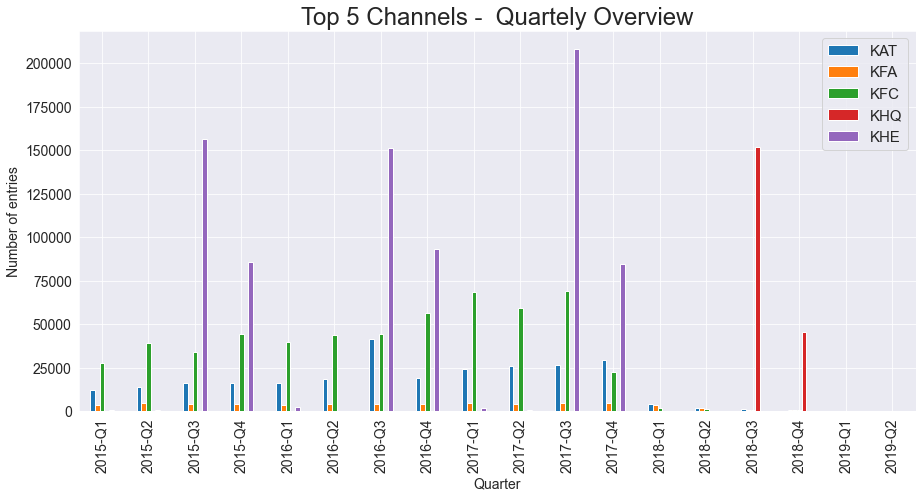

In [207]:
df_entrydate_by_channel[['KAT', 'KFA', 'KFC', 'KHQ', 'KHE']].plot(kind='bar', figsize=(15, 7))

# set the title and axis labels
plt.title('Top 5 Channels -  Quartely Overview', fontsize=24)
plt.xlabel('Quarter')
plt.ylabel('Number of entries')
plt.rcParams.update({'font.size': 5})
# set the font size of the legend
plt.legend(fontsize=15)
# show the plot
plt.show()

In [208]:
df_entrydate_by_channel

entry_channel,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,RED,others
quarter_entry,,,,,,,,,,,
2015-Q1,11956,3376,28022,3185,1018,56,36,35,0,67,1825
2015-Q2,14212,4588,39471,472,635,100,79,38,0,73,1890
2015-Q3,16443,3954,33829,15402,156419,85,83,141,22,85,2021
2015-Q4,16020,4180,44522,2818,86041,136,122,169,0,50,1425
2016-Q1,16409,3333,39714,238,2581,92,95,74,0,53,1743
2016-Q2,18759,4413,43705,51,377,48,90,55,0,90,1439
2016-Q3,41603,4328,44393,17,151229,111,95,93,41,91,715
2016-Q4,19007,4282,56538,0,93135,125,116,194,1,30,2659
2017-Q1,24103,4751,68634,0,1701,154,143,201,17,4512,1112


<font color=green size=+1><b> Comments</b></font>

New registries vary across the different channels and across years: KHE is the main channel of acquisition during the seasons that have been seen before in this report. However, in Q3 it seems to be no longer used as in previous years and becomes the second-lowest performing entry channel (in terms of absolute number of users).

Channels like KAT, KFA and KFC, even though amongst themselves they have different numbers, they seem the have been steady channels of customer acquisition until 2018, year in which they seem to start being disused.

Channels once performing well start reducing performance progressively from 2018. This trend matches the rise in performance of other channels like KHK and specially KHM and KHN, which start gaining importance during 2018, year during which those are the main entry channels. RED also has a fair spike in user acquisition, specially during 2017.



<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> Identify the distribution of products for customers that join for the first time (from 2018)</b></font>

Due to the fact that only partitions of the data since January 2018 are available, the state of customers at the moment of joining cannot be known if they joined before the aforementioned date. In order to evaluate which products were acquired for new joining customers, the focus will be put on customers joining from 28-01-2018 onwards.

In [209]:
check_dates_df = df.loc[df['entry_date']>='2018-01-28'].copy()

check_dates_df.set_index('entry_date', inplace=True)

check_dates_df.drop_duplicates('pk_cid', inplace=True)

Text(0.5, 0.98, 'Monthly evolution of product features from Entry date')

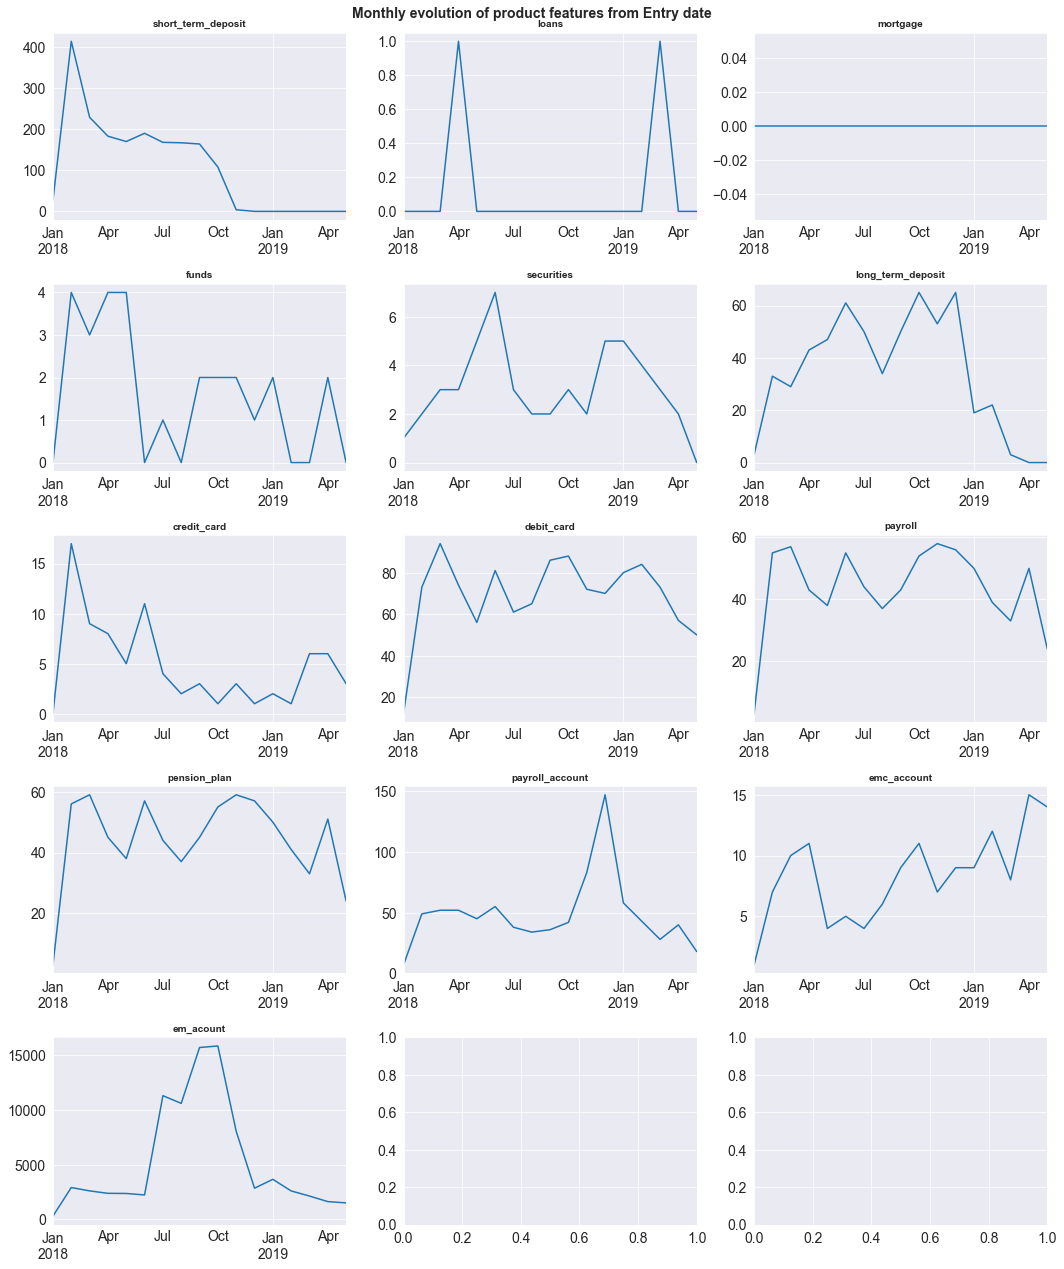

In [210]:
plt.rcParams.update({'font.size': 14})
# instantiate figure
fig, axes = plt.subplots(nrows=5, ncols=3, figsize =(15,18)) #  
axes = axes.flat

# plot
for i, col in enumerate(products):
    check_dates_df.resample('M')[col].sum().plot(ax = axes[i])
    axes[i].set_title(col, fontsize = 10, fontweight = 'bold')
    axes[i].set_xlabel("")

# format and title
fig.tight_layout()
plt.subplots_adjust(top = 0.96)
fig.suptitle('Monthly evolution of product features from Entry date', fontsize = 14, fontweight = 'bold')

<font color=green size=+1><b> Comments</b></font>

After analyzing the data, several trends can be identified in the performance of different financial products. The short-term deposit product appears to be struggling, with new registrations decreasing over time and retention being low for already sold units. Similarly, loans and mortgages have low sales numbers, and it is unclear whether the revenue generated from these products is worth keeping them in the company's portfolio. The funds and securities product also has low numbers, indicating the need for further analysis of its cost-benefit ratio.

The payroll account had a spike in December 2019, but it is unclear whether this was due to new purchases or existing customers. The EM account is the best performing product, with a seasonal increase in users that confirms the effectiveness of the entry channel used. Other products have varying levels of customer acquisition, but generally have low numbers compared to the best performing products.

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> 2019-05: Number of Products Distribution</b></font>

In [211]:
count_per_total_products_2019 = df_2019_05["Total_products"].value_counts().to_frame().reset_index()
count_per_total_products_2019.columns = ["nr_products", "nr_customers"]
count_per_total_products_2019.sort_values("nr_products", ascending = True, inplace = True)
count_per_total_products_2019["pct_over_total"] = count_per_total_products_2019["nr_customers"]/count_per_total_products_2019["nr_customers"].sum()
count_per_total_products_2019.head()

,nr_products,nr_customers,pct_over_total
1,0.00,108751,0.25
0,1.00,268226,0.61
2,2.00,38690,0.09
3,3.00,11496,0.03
4,4.00,8478,0.02


The table provides a useful summary of the distribution of products among customers and can help identify potential opportunities for cross-selling or targeting specific customer groups. For example, the bank may want to focus on increasing the number of products held by customers who currently only have 1 product, as they represent a significant portion of the customer base.

<font color=green size=+2><b> 2019-05: Number of Products Distribution -  Not active customers</b></font>

In [212]:
df_2019_05_Not_Active=df_2019_05[df_2019_05['active_customer']==0]

In [213]:
count_per_total_products_2019_NA = df_2019_05_Not_Active["Total_products"].value_counts().to_frame().reset_index()
count_per_total_products_2019_NA.columns = ["nr_products", "nr_customers"]
count_per_total_products_2019_NA.sort_values("nr_products", ascending = True, inplace = True)
count_per_total_products_2019_NA["pct_over_total"] = count_per_total_products_2019_NA["nr_customers"]/count_per_total_products_2019_NA["nr_customers"].sum()
count_per_total_products_2019_NA.head()

,nr_products,nr_customers,pct_over_total
1,0.00,105982,0.39
0,1.00,164039,0.61
2,2.00,829,0.00
3,3.00,23,0.00
4,4.00,1,0.00


The majority (60%) of non-active customers have only one product.
39% of non-active customers do not have any products at all.
A very small percentage of non-active customers have 2, 3, or 4 products.
The percentage of non-active customers with more than one product is significantly lower than the percentage of active customers with more than one product, suggesting that having multiple products is a strong indicator of customer engagement and activity.

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">

<font color=green size=+2><b> Extra Visualizations</b></font>

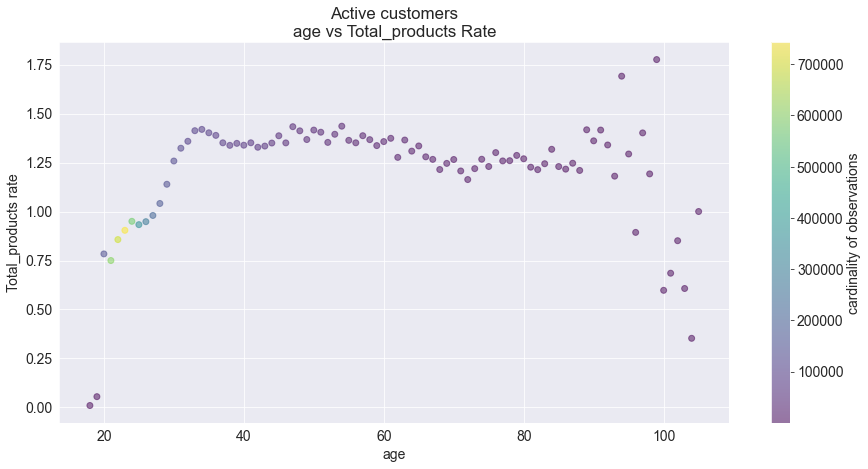

In [263]:
feature_vs_target_w_lengh(df, "age", "Total_products",grouped=False)

The graph plot the average rate of products per age group, highlighting the concentration of customers. Most customers are in the 20-30s age group, and the number of products is below 1. As the age increased the average number of products increased but the population decreases.  

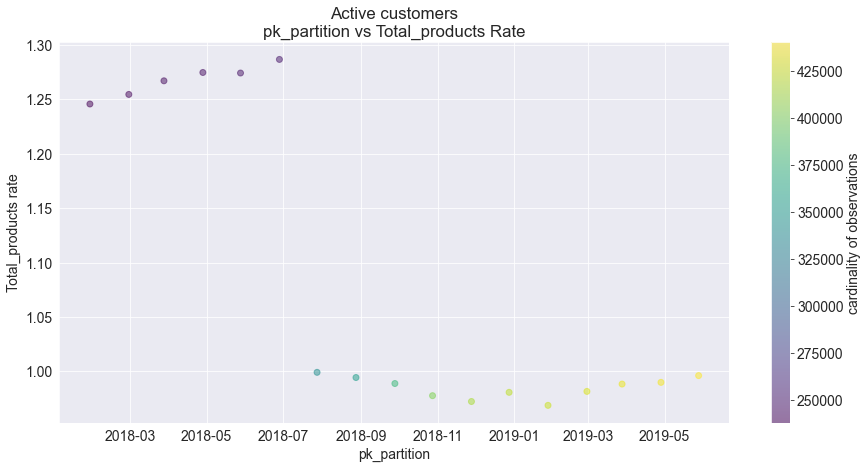

In [264]:
feature_vs_target_w_lengh(df, "pk_partition", "Total_products", grouped = False)

The graph shows clearly the rate decreasing  with the introduction of new customers